In [3]:
import pandas as pd
df1 = pd.read_pickle("movies1.pkl")
df2 = pd.read_pickle("movies2.pkl")
df3 = pd.read_pickle("movies3.pkl")
df = pd.concat([df1,df2, df3]).drop_duplicates().reset_index(drop=True)
len(df)

29940

In [20]:
#Preprocess
df_1 = df[df[df.columns[5:]].sum(axis = 1) != 0]
df_1 = df_1[df_1['Year'] != 2016]
print(len(df_1))

28372


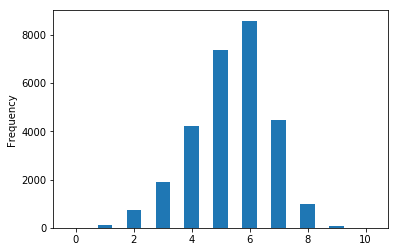

In [21]:
import matplotlib.pyplot as plt
r = df_1['Rating']
r.plot(kind='hist',histtype = 'bar', align = "left",rwidth = 0.5,bins=[0,1, 2,3, 4, 5, 6, 7, 8,9,10,11])
plt.show()

Over 44971, From the dirstribution of the ratings. We found the ratings centered around 6

In [17]:
import numpy as np
r.describe()


,Name,Rating,Year,Votes,Gross,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Biography,Genre_Comedy,...,Genre_Mystery,Genre_News,Genre_Reality-TV,Genre_Romance,Genre_Sci-Fi,Genre_Sport,Genre_Talk-Show,Genre_Thriller,Genre_War,Genre_Western


In [23]:
df_y1 = df_1[np.logical_and(df_1['Year'] >= 1950, df_1['Year'] < 1960)]
df_y2 = df_1[np.logical_and(df_1['Year'] >= 1960, df_1['Year'] < 1970)]
df_y3 = df_1[np.logical_and(df_1['Year'] >= 1970, df_1['Year'] < 1980)]
df_y4 = df_1[np.logical_and(df_1['Year'] >= 1980, df_1['Year'] < 1990)]
df_y5 = df_1[np.logical_and(df_1['Year'] >= 1990, df_1['Year'] < 2000)]
df_y6 = df_1[df_1['Year'] >= 2000]

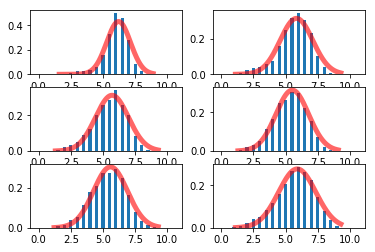

In [31]:
from scipy.stats import norm
df_y = [df_y1, df_y2, df_y3, df_y4, df_y5, df_y6]
i = 0
for col in df_y:
    ax = plt.subplot2grid((3,2), (i//2, i%2))
    i = i + 1
    r = col['Rating']
    ax.hist(r, histtype = 'bar', align = "left",rwidth = 0.5,bins=[0,0.5, 1,1.5, 2,2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8,8.5, 9,9.5, 10,10.5, 11], normed=True)
    
    x = np.linspace(r.min(), r.max(), r.shape[0])

    rv = norm(loc = np.mean(r), scale = np.std(r))
    ax.plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()

The formula for calculating the Top Rated 250 Titles gives a true Bayesian estimate:
weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C
Where:
 - R = average rating for across movie genres = (Rating)
 - v = number of votes for across movie genres = (votes)
 - m = a good number of votes to rely on the rating based on votes (m as the average number of votes)
 - C = the mean ratings of all movies (currently 7.0)

In [35]:
def get_values(df):
    v = []
    R = []
    for genre in df.columns[5:]:

        v1 = sum(df[df[genre] == 1]['Votes'])
        r1 = np.mean(df[df[genre] == 1]['Rating'])
        R.append(r1)
        v.append(v1)
    m = np.mean(df['Votes'])
    C = np.mean(df['Rating'])
    return np.asarray(R), np.asarray(v), m, C
def true_bayesian_estimate(df):
    R, v, m, C = get_values(df)
    return (v/(v+m))*R + (m/(v+m))*C

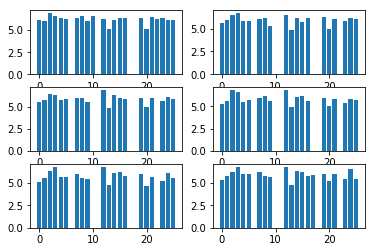

In [56]:
i = 0
for df in df_y:
    ax = plt.subplot2grid((3,2), (i//2, i%2))
    i = i + 1
    y = true_bayesian_estimate(df)
    y = np.nan_to_num(y)
    x = df.columns[5:]
    plt.bar(range(y.shape[0]), y)
plt.show()

From this exploration, we found several generes have rae corresponding values in other variables. We decide to remove those generes for later linear regression

In [57]:
#remove genres
generes = df_1.columns[5:]
remove_genre = []
for genre in generes:
    if((df_1[genre] == 0).all()):
        remove_genre.append(genre)
df_11 = df_1.drop(remove_genre, axis = 1)

# Gross as an indicator of popularity in movie market  
## The average gross over years
To find the trend of the Gross over years, apply the sliding average on this time series data to smooth out short-term flucatuations and find the longer-term trend.

In [58]:
def parse_gross(s):    
    try:
        if (s[-1]=="M"):
            return (float(s[1:-1]))
    except:
        return np.nan
df_11["Gross"] = df_11["Gross"].apply(parse_gross)
df_11["Votes"] = pd.to_numeric(df_11["Votes"])


In [70]:
from collections import deque

class SlidingAverage:
    def __init__(self,k):
        """ Initializes a sliding average calculator which keeps track of the average of the last k seen elements. 
        
        Args: 
            k (int): the number of elements to average (the half-width of the sliding average window)
        """
        self.k = k
        self.s = deque(maxlen = 2*k + 1)
        self.s.extend([None] * k)
        self.sum = 0.0
        self.num = 0.0
        
    def update(self,x):
        """ Computes the sliding average after having seen element x 
        
        Args:
            x (float): the next element in the stream to view
            
        Returns: 
            (float): the new sliding average after having seen element x, if it can be calculated
        """
        self.s.append(x)
        if x is not None:
            self.sum = self.sum + x
            self.num = self.num + 1
        if len(self.s) == 2*(self.k) + 1:
            slidingavg = self.sum/(self.num)
            if (not (self.s[0] is None)):
                self.num = self.num - 1
                self.sum = self.sum - self.s[0]

            return slidingavg
        return None
    

def compute_sliding_averages(s, k):
    """ Computes the sliding averages for a given Pandas series using the SlidingAverage class. 
    
    Args:
        s (pd.Series): a Pandas series for which the sliding average needs to be calculated
        k (int): the half-width of the sliding average window 
        
    Returns:
        (pd.Series): a Pandas series of the sliding averages
    
    """
    if k == 0:
        return s
    sa = SlidingAverage(k)
    s1 = pd.Series()
    snew = [val for val in map(sa.update, s) if val is not None]  
    snew.extend([val for val in map(sa.update, [None]*k) if val is not None])
    s1 = s1.append(pd.Series(snew))
    return s1
subdf = df_11.dropna()
gross_y = subdf.groupby(['Year'])['Gross'].mean()
gross_y_slide_average = compute_sliding_averages(pd.Series(gross_y),5)


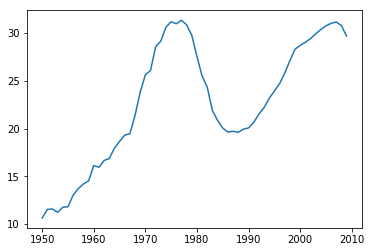

In [73]:
plt.plot(range(1950, 2010), gross_y_slide_average)
plt.show()